<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Learning-Goals" data-toc-modified-id="Learning-Goals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Learning Goals</a></span></li><li><span><a href="#Context" data-toc-modified-id="Context-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Context</a></span></li><li><span><a href="#Boundary-conditions" data-toc-modified-id="Boundary-conditions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Boundary conditions</a></span></li><li><span><a href="#1D-diffusion-from-a-constant-concentration-boundary" data-toc-modified-id="1D-diffusion-from-a-constant-concentration-boundary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>1D diffusion from a constant-concentration boundary</a></span></li><li><span><a href="#1D" data-toc-modified-id="1D-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>1D</a></span></li><li><span><a href="#Quantification-of-the-error" data-toc-modified-id="Quantification-of-the-error-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Quantification of the error</a></span></li><li><span><a href="#2D" data-toc-modified-id="2D-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>2D</a></span></li></ul></div>

# 2D Transient simulation

## Learning Goals

- Being able to perform a 2D diffusion problem with inhomogeneous diffusion
- Being able to assess the accuracy by comparing solution of a homogeneous problem to an analyitical solution
- Being able to define the gridsize and timesteps to have reasonable computation time vs accuracy
- Use the precedent approach to model a more complicated problem

## Context

We want to study the diffusion of a contaminant in a geological context. The different geological layers and zones induce that the diffusion is not the same in every direction. We want to model these effects that diffusion is stopped on some boundary, that diffusion avoids certain areas of low diffusivity, ...

To start that, we need a transient 2D model whose parameters are well defined. In order to assess the accuracy of the method, we will start by using the approach on simple cases for which an analytical solution is known. That will allow to define the timestep, gridsize, to have a reasonable agreement with analytical solution.

From then, we will be able to model any similar situation.

## Boundary conditions

Different types of boundary conditions can be encountered. So far, we have only used a boundary condition specifying the value of the unknown at one point (these are called Dirichlet boundary condition). In some case, a flux  is specified as a boundary condition, e.g. a certain amount of water/gas is injected at one boundary at a rate of 1 kg/s. These conditions will specify the derivative of the unknowns.

A usual boundary condition is a no-flux boundary condition, meaning the solutes cannot go through a boundary. No diffusive flux means that the difference in concentration is zero. Thus, it specifies a zero-derivative at the boundary. Physically, this represents particle bouncing on a reflecting surface: every particle colliding with the surface is reflected back. Therefore, zooming on the boundary, the derivative of the concentration is zero.

## 1D diffusion from a constant-concentration boundary

Let us describe the diffusion of a contaminant in soils where a constant concentration is applied at onne boundary. It can be shown that the analytical solution to such a problem can be represented by the following equation:

\begin{equation}
c(x,t) = c_0  \text{erfc}\left( \frac{x}{\sqrt{4Dt}}  \right)
\end{equation}

where erfc$(x)$ is the error function. Let us look at this solution for different timesteps.


In [1]:
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy import special

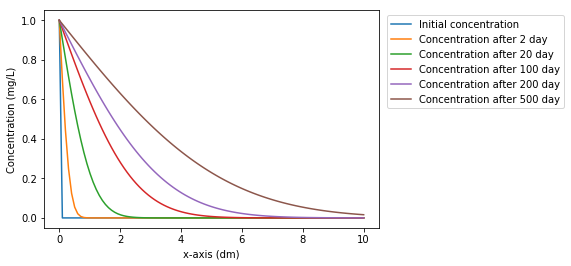

In [2]:
N_tstep = 6
T = [0, 2, 20, 100, 200, 500]

N_x = 100
Width = 10
x = np.linspace(0, Width, N_x)
c = np.zeros((N_tstep, N_x))
a = 1
c0 = 1
Diff = 2e-9 * 100 * 24 * 3600
c[0, 0] = c0

plt.plot(x, c[0, :], label="Initial concentration")

for t in range(1, N_tstep):
    for i in range(N_x):
        DENOM = np.sqrt(4 * Diff * T[t])
        c[t, i] = c0 * special.erfc((x[i]) / DENOM)
    plt.plot(x, c[t, :], label="Concentration after %.0f day" % T[t])


plt.xlabel("x-axis (dm)")
plt.ylabel("Concentration (mg/L)")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
# noqa

If we consider a 2D system, without any heterogeneity along the y-axis, the previous solution is valid for each y axis, and you can imagine that the previous plot is a transverse vision of the evolution of the front. This means that, whatever the value of  $y$:

\begin{equation}
  c(x,y_1,t) = c(x,y_2,t) \quad \forall y_1,y_2,x,t
\end{equation}

In the next few cells, we define some function which we will use throughout the rest of the assignment.

- avg(Di,Dj) computes the average diffusion coefficient to compute the flux between two cells with different D
- ind_to_row_col(...) function to know which column and which row correspond to which index
- Build_2D_Matrix(...) is the same function than before, generalized to 2D and multiple boundary conditions

Then we have defined two classes (objects) which will store informations to make it easier to pass to functions.

- class boundary: creates a boundary which has a type and an assigned value ("const" means constant-concentration boundary, and its attribute "val" is the value of this concentration. otherwise, it is a flux boundary condition, and the attribute "0" expresses the derivative at that boundary).
- class def_prob: puts every relevant parameter in an object to be given to Build_2d_Matrix

In [3]:
# this function deals with harmonic averaging when diffusion is not the same everywhere.
# It doesn't change anything when diffusion is homogeneous but you can try to see how it affects the behavior.


def avg(Di, Dj):
    """
    Computes the harmonic average between two values Di and Dj
    Returns 0 if either of them is zero
    """
    if (Di * Dj) == 0:
        return 0
    else:
        return 2 / (1 / Di + 1 / Dj)

In [4]:
def ind_to_row_col(ind, nrows, ncol):
    """
    in a 2D array, returns the row and column value
    associated with a certain index
    Bottom left is index is zero (0-th row, 0-th column)
    while index one is the 0-th row and 1st column
    """
    if ind > nrows * ncol - 1:
        return 0

    row = int(np.floor(ind / ncol))
    col = int(ind - row * ncol)
    return row, col

In [5]:
def Build_2D_Matrix(BC, Prob, D, Q):
    """
    Constructs a coefficient matrix A and an array b corresponding to the system Ac = b
    This system corresponds either to a 1D or 2D problem
    Parameters:
    --------------
    BC: contains boundary objects defining the boundary conditions
    nx (int): amounts of cells on the x-axis
    ny (int): amount of cells on the y-axis
    D (float array): values of the diffusion coefficient at each grid point(dm^2/day)
    Width_X (float): x-extent of the domain
    Width_Y (float): y-extent of the domain
    poro (float): porosity value
    Q (float array): volumetric source term (mg/L/day)
    Returns the matrix A, and the array b to solve the
    discretized 1D diffusion problem Ax = b

    ----------
    """
    Number_of_rows = Prob.ny
    Number_of_col = Prob.nx
    n = Prob.nx * Prob.ny
    is1D = False
    if Number_of_rows == 1 or Number_of_col == 1:
        is1D = True
        Number_of_col = n
    Matrix = np.zeros((n, n))
    RHS = np.zeros(n)

    if is1D:
        dx = max(Prob.Wx, Prob.Wy) / (max(Prob.ny, Prob.nx) - 1)
        coef_x = Prob.poro / dx / dx
    else:
        dx = Prob.Wx / (Prob.ny - 1)
        dy = Prob.Wy / (Prob.nx - 1)
        coef_x = Prob.poro / dx / dx
        coef_y = Prob.poro / dy / dy

    for ind in range(n):
        if is1D:
            j = ind
            i = -1
        else:
            i, j = ind_to_row_col(ind, Number_of_rows, Number_of_col)
        if j == 0:  # WEST BOUNDARY
            if BC[0].btype == "const":
                RHS[ind] = BC[0].val
                Matrix[ind, ind] = 1
            else:  # flux boundary condition
                Matrix[ind, ind] = 1
                Matrix[ind, ind + 1] = -1
                RHS[ind] = BC[0].val / dx

        elif j == Number_of_col - 1:  # EAST BOUNDARY
            if BC[2].btype == "const":
                RHS[ind] = BC[2].val
                Matrix[ind, ind] = 1
            else:  # flux boundary condition
                Matrix[ind, ind] = 1
                Matrix[ind, ind - 1] = -1
                RHS[ind] = BC[2].val / dx
        elif i == 0 and Prob.ny > 1:  # SOUTH BOUNDARY
            if BC[3].btype == "const":
                RHS[ind] = BC[3].val
                Matrix[ind, ind] = 1
            else:  # flux boundary condition
                Matrix[ind, ind] = 1
                Matrix[ind, ind + Number_of_col] = -1
                RHS[ind] = BC[3].val / dy

        elif i == Number_of_rows - 1 and Prob.ny > 1:  # NORTH BOUNDARY
            if BC[1].btype == "const":
                RHS[ind] = BC[0].val
                Matrix[ind, ind] = 1
            else:  # flux boundary condition
                Matrix[ind, ind] = 1
                Matrix[ind, ind - Number_of_col] = -1
                RHS[ind] = BC[1].val / dy
        else:
            if is1D:
                North = 0
                South = 0
                RHS[ind] = Q[ind]
                East = coef_x * avg(D[ind + 1], D[ind])
                West = coef_x * avg(D[ind - 1], D[ind])
            else:
                North = coef_y * avg(D[i, j], D[i + 1, j])
                South = coef_y * avg(D[i, j], D[i - 1, j])
                East = coef_x * avg(D[i, j], D[i, j + 1])
                West = coef_x * avg(D[i, j], D[i, j - 1])
                Matrix[ind, ind + Number_of_col] = -North
                Matrix[ind, ind - Number_of_col] = -South
                RHS[ind] = Q[i, j]

            Matrix[ind, ind] = East + West + North + South
            Matrix[ind, ind + 1] = -East
            Matrix[ind, ind - 1] = -West

    return Matrix, RHS

In [6]:
class boundary:
    btype: str
    val: float

    def __init__(self, btype, val):
        self.btype = btype
        self.val = val

In [7]:
class def_prob:
    nx: int
    ny: int
    poro: float
    Wx: float
    Wy: float

    def __init__(self, nx, ny, poro, Wx, Wy):
        self.nx = nx
        self.ny = ny
        self.poro = poro
        self.Wx = Wx
        self.Wy = Wy

In [8]:
# Here we create 4 boundaries, West has a constant concentration at c0, East has a constant boundary at 0;
West = boundary("const", val=c0)
East = boundary("const", val=0)

# The other south and north boundaries have a zero flux (impermeable)

North = boundary("zero-flux", val=0)
South = boundary("zero-flux", val=0)

BC = [West, North, East, South]
# The latter array BC will be send to the different functions

# Homogeneous problem

## 1D
We will use the different defined function (which also work in 1D) to assess a reasonable timestep and gridsize so that the error is acceptable.


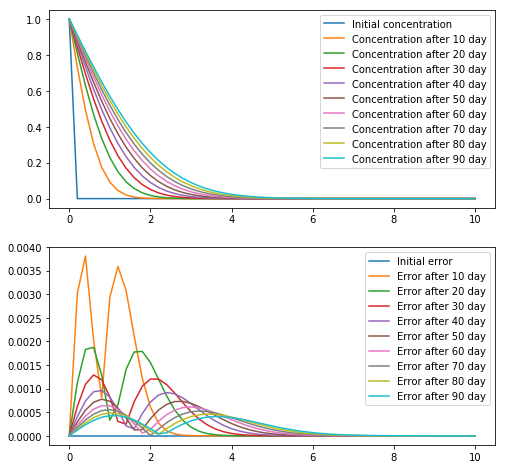

In [9]:
N_x = 51
N_y = 1
Width_X = Width
Width_Y = 0
n = N_x * N_y
x = np.linspace(0, Width, N_x)
c_init = np.zeros(N_x)
c_init[0] = c0
D = Diff * np.ones(n)
poro = 0.4
prob = def_prob(N_x, N_y, poro, Width_X, Width_Y)
Q = np.zeros(n)
A, b = Build_2D_Matrix(BC, prob, D, Q)


Abis = np.zeros((n, n))
Bbis = np.zeros(n)
dt = 0.2
Tf = 100
nTstp = int(Tf / dt)
Number_of_fig = 10
n_of_tstep_before_fig = int(nTstp / Number_of_fig)


c = np.zeros(((n, Number_of_fig)))
err = np.zeros(((n, Number_of_fig)))
c[:, 0] = c_init
nfig = 1
Time = 0
c_real = np.zeros(n)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x, c_init, label="Initial concentration")
ax2.plot(x, err[:, 0], label="Initial error")
v = c_init


for t in range(nTstp - 1):
    for i in range(n):
        Abis[i, i] = poro / dt
        Bbis[i] = v[i] * poro / dt
    Aa = A + Abis
    bb = b + Bbis
    v = np.linalg.solve(Aa, bb)
    Time = Time + dt
    if (t + 1) % n_of_tstep_before_fig == 0 and t > 0:
        for i in range(n):
            c[i, nfig] = v[i]
            DENOM = np.sqrt(4 * Diff * (t + 1) * dt)
            c_real[i] = c0 * special.erfc((x[i]) / DENOM)
            err[i, nfig] = abs(c[i, nfig] - c_real[i])

        ax1.plot(x, c[:, nfig], label="Concentration after %.0f day" % Time)
        ax2.plot(x, err[:, nfig], label="Error after %.0f day" % Time)
        nfig = nfig + 1


ax1.legend()
ax2.legend()

## Quantification of the error

One may realize that the previous visualization of the error is not particularly helpful. We would like to quantify the error using only one real number, so that comparison is easier. This is the concept of the *norm*. It is defined in "numpy.linalg.norm". The norm of a vector $\overrightarrow{x}$ is usually written

\begin{equation}
\lvert \lvert \overrightarrow{x}\lvert\lvert
\end{equation}

There exists many type of norm

Norm-1:

\begin{equation}
\lvert\lvert\overrightarrow{x}\lvert\lvert_1 = \sum_i^N |x_i|
\end{equation}

Norm-2 (notion of distance)

\begin{equation}
\lvert\lvert\overrightarrow{x}\lvert\lvert_2 = \sqrt{\sum_i^N |x_i|^2}
\end{equation}


The infinte-norm:

\begin{equation}
\lvert\lvert\overrightarrow{x}\lvert\lvert_\infty = max_i  \{ |x_i| \}
\end{equation}

We can also define the n-norm, but the three previous one are most commonly used.

\begin{equation}
\lvert\lvert\overrightarrow{x}\lvert\lvert_n = \sqrt[n]{\sum_i^N |x_i|^n}
\end{equation}

Use the 2nd norm to see the evolution of the global error with the timestep.

0.00811485927081457


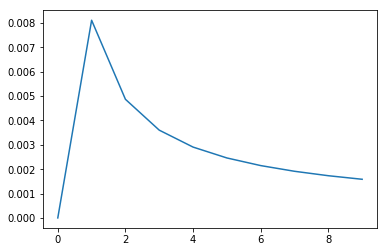

In [10]:
err_norm = np.zeros(nfig)
for i in range(nfig):
    err_norm[i] = np.linalg.norm(err[:, i])

plt.plot(err_norm)
maxerr = max(err_norm)
print(maxerr)

Now see the influence of modifying the number of gridblocks and timestep and choose a good compromise between accuracy, and computation time.

maxerr=0.013870279176335376


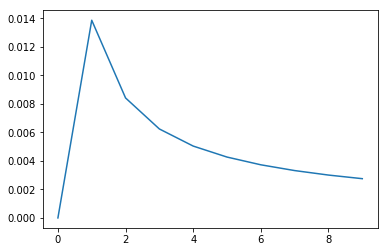

In [11]:
N_x = 31
N_y = 1
Width_X = Width
Width_Y = 0
n = N_x * N_y
x = np.linspace(0, Width, N_x)
c_init = np.zeros(N_x)
c_init[0] = c0
D = Diff * np.ones(n)
prob = def_prob(N_x, N_y, poro, Width_X, Width_Y)
Q = np.zeros(n)
A, b = Build_2D_Matrix(BC, prob, D, Q)


Abis = np.zeros((n, n))
Bbis = np.zeros(n)
dt = 0.25
Tf = 100
nTstp = int(Tf / dt)
Number_of_fig = 10
n_of_tstep_before_fig = int(nTstp / Number_of_fig)


c = np.zeros(((n, Number_of_fig)))
err = np.zeros(((n, Number_of_fig)))
c[:, 0] = c_init
nfig = 1
Time = 0
c_real = np.zeros(n)
v = c_init


for t in range(nTstp - 1):
    for i in range(n):
        Abis[i, i] = poro / dt
        Bbis[i] = v[i] * poro / dt
    Aa = A + Abis
    bb = b + Bbis
    v = np.linalg.solve(Aa, bb)
    Time = Time + dt
    if (t + 1) % n_of_tstep_before_fig == 0 and t > 0:
        for i in range(n):
            c[i, nfig] = v[i]
            DENOM = np.sqrt(4 * Diff * (t + 1) * dt)
            c_real[i] = c0 * special.erfc((x[i]) / DENOM)
            err[i, nfig] = abs(c[i, nfig] - c_real[i])

        nfig = nfig + 1


ax1.legend()
ax2.legend()

err_norm = np.zeros(nfig)
for i in range(nfig):
    err_norm[i] = np.linalg.norm(err[:, i])

plt.plot(err_norm)
maxerr = max(err_norm)
print(f"maxerr={maxerr}")

## 2D

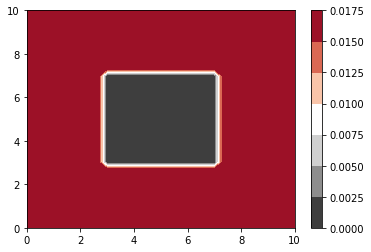

In [12]:
Width_X = 10
Width_Y = 10
N_x = 31
N_y = 31

D = Diff * np.ones((N_y, N_x))
Q = np.zeros((N_y, N_x))
poro = 0.4
dt = 0.25  # days
c_init = np.zeros((N_y, N_x))

x = np.linspace(0, Width_X, N_x)
y = np.linspace(0, Width_Y, N_y)

for i in range(N_y):
    for j in range(N_x):
        if j == 0:
            c_init[i, j] = c0


for i in range(N_y):
    for j in range(N_x):
        if (
            abs(x[j] - Width_X / 2) <= 0.2 * Width_X
            and abs(y[i] - Width_Y / 2) <= 0.2 * Width_Y
        ):
            D[i, j] = Diff / 100

fig, ax = plt.subplots()
cm = cmap.get_cmap("RdGy_r")
plt.contourf(x, y, D, cmap=cm)
plt.colorbar()
# noqa

In [13]:
def mat2vec(c, nrow, ncol):
    n = nrow * ncol
    v = np.zeros(n)
    for ind in range(n):
        i, j = ind_to_row_col(ind, nrow, ncol)
        v[ind] = c[i, j]

    return v

In [14]:
def vec2mat(v, nrow, ncol):
    n = 0
    c = np.zeros((nrow, ncol))
    for i in range(nrow):
        for j in range(ncol):
            c[i, j] = v[n]
            n = n + 1
    return c

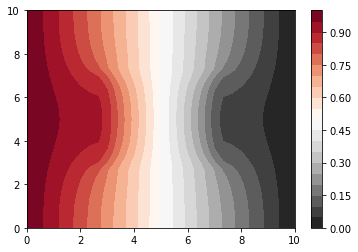

In [15]:
### Asymptotic behavior
prob = def_prob(N_x, N_y, poro, Width_X, Width_Y)
Q = np.zeros((N_y, N_x))
A, b = Build_2D_Matrix(BC, prob, D, Q)
v = mat2vec(c_init, N_y, N_x)
v = np.linalg.solve(A, b)
c = vec2mat(v, N_y, N_x)

plt.contourf(x, y, c, 20, cmap=cm)
plt.colorbar()

In [16]:
prob = def_prob(N_x, N_y, poro, Width_X, Width_Y)
Q = np.zeros((N_y, N_x))
A, b = Build_2D_Matrix(BC, prob, D, Q)

v = mat2vec(c_init, N_y, N_x)

n = N_x * N_y
Abis = np.zeros((n, n))
Bbis = np.zeros(n)
nTstp = 160
n_of_tstep_before_fig = 10
Number_of_fig = int(1 + nTstp / n_of_tstep_before_fig)
c = np.zeros(((N_y, N_x, Number_of_fig)))
c[:, :, 0] = c_init
dt = 5
nfig = 1

for t in range(nTstp - 1):
    for i in range(n):
        Abis[i, i] = poro / dt
        Bbis[i] = v[i] * poro / dt
    Aa = A + Abis
    bb = b + Bbis
    v = np.linalg.solve(Aa, bb)
    if t % n_of_tstep_before_fig == 0 and t > 0:
        c[:, :, nfig] = vec2mat(v, N_y, N_x)
        nfig = nfig + 1

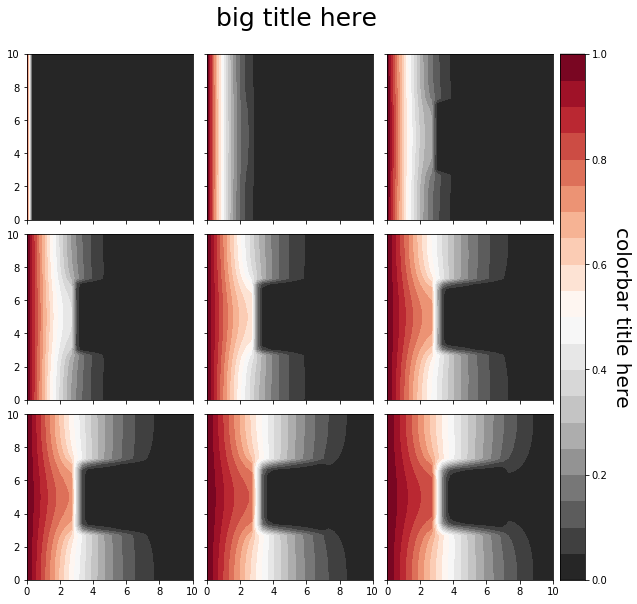

In [17]:
# https://jdhao.github.io/2017/06/11/mpl_multiplot_one_colorbar/
# https://matplotlib.org/tutorials/toolkits/axes_grid.html

fig = plt.figure(figsize=(10, 10))

ntimesteps = nfig
time_steps = np.array([0, 1, 2, 3, 5, 8, 9, 12, 15])

grid = AxesGrid(
    fig,
    111,
    nrows_ncols=(3, 3),
    axes_pad=0.20,
    cbar_mode="single",
    cbar_location="right",
    cbar_pad=0.1,
)

for time_index, the_ax in zip(time_steps, grid):
    the_ax.axis("equal")
    im = the_ax.contourf(x, y, c[:, :, time_index], 20, cmap=cm)

cbar = grid.cbar_axes[0].colorbar(im)
cbar.set_label_text("colorbar title here", rotation=270, size=20, va="bottom")
fig.suptitle("big title here", y=0.9, size=25, va="bottom");